# Schooling in Xenopus tadpoles

Playground to troubleshoot analysis procedures.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial

In [2]:
def preProcess(d):
    d.columns = ['Tad']+[d.columns[i].replace(' ','') for i in range(1,len(d.columns))] # Remove spaces in column names
    d.insert(1, 'Frame', 0)
    
    for i in range(1,d.shape[0]):
        if d.loc[i,'Tad']<d.loc[i-1,'Tad']:
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']+1
        else:
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']
    # Note that d['Frame'][i] wouldn't have worked because of chain slicing: applying 2nd slice after the 1st would
    # have created a copy of the dataframe, and so wouldn't have transformed the original dataframe
    d.Frame = d.Frame.astype(int) # Not sure why it becomes float, but I don't like it      
    return d

d = pd.read_csv('data/control.csv')
d = preProcess(d)
print(d[:5])

   Tad  Frame  Area  Min  Min  Max      X       Y
0    1      0     0  215  215  215  7.391  14.783
1    2      0     0  128  128  128  7.232  14.643
2    3      0     0  239  239  239  8.850  14.623
3    4      0     0  156  156  156  8.670  14.443
4    5      0     0  236  236  236  7.751  12.426


Standard ImageJ format. X and Y are coordinates; every odd row is a tadpole head; every odd row is a tail. The first row goes from 1 to 2n (where n is the number of tadpoles in each frame), then starts anew. We manually add a frame counter.

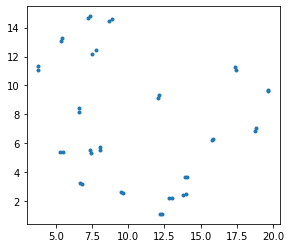

In [3]:
# Check if the data makes sense: plot frame 0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(d.loc[d.Frame==0,'X'],d.loc[d.Frame==0,'Y'],'.');
ax.set_aspect('equal')

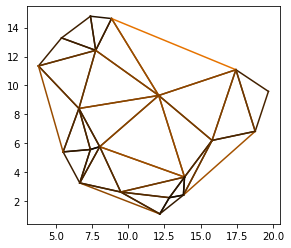

In [72]:
def getNFrames(d):
    return max(d.Frame)

def extractTads(d,frame):
    '''Splits the data into xy of heads and relative xy of tails'''
    xy = d.loc[d.Frame==frame,['X','Y']].to_numpy()
    heads = xy[0::2,:]
    return (heads , xy[1::2,:]-heads)    

def findNeighbors(xy):
    ''''''
    tri = scipy.spatial.Delaunay(xy,qhull_options="QJ").simplices # Help says that this "QJ" is needed if you want to
                                                                  # have all tadpoles in the output (even lonely ones)
    listOfPairs = [] # Array of tuples to describe all pairs of points
    for i in range(tri.shape[0]):
        t = [tuple(tri[i,[0,1]]) , tuple(tri[i,[1,2]]) , tuple(tri[i,[2,0]])]
        for p in t:
            if not p in listOfPairs:
                listOfPairs += [p]
    return listOfPairs

def findDistances(xy,pairs):
    '''Distances between pairs of tadpoles'''
    return [np.linalg.norm(xy[p[0],]-xy[p[1],]) for p in pairs]

(xy,tails) = extractTads(d,frame=0)
pairs = findNeighbors(xy)
dist = findDistances(xy,pairs)

fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(pairs)):
    p = pairs[i]
    #ax.plot([xy[p[0],0] , xy[p[1],0]],[xy[p[0],1] , xy[p[1],1]]) # Point
    ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)), color=np.array([1,0.5,0])*dist[i]/max(dist)*0.9) # Same as above, but weirdly written ;)
ax.set_aspect('equal')

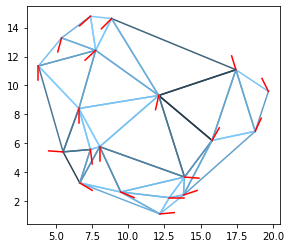

In [71]:
def findAngles(tails,pairs):
    '''Angles between pairs of tadpoles'''
    norms = [np.linalg.norm(tails[i,]) for i in range(tails.shape[0])]
    a = [np.arccos(np.dot(tails[p[0],],tails[p[1],])/(norms[p[0]]*norms[p[1]])) for p in pairs]
    return np.array(a)

ang = findAngles(tails,pairs)

def niceTadFigure(ax):
    for i in range(len(pairs)):
        p = pairs[i]
        #ax.plot([xy[p[0],0] , xy[p[1],0]],[xy[p[0],1] , xy[p[1],1]]) # Point
        ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)), 
                color=np.array([0.5,0.8,1])*(1-ang[i]/4))
    for i in range(xy.shape[0]):
        nm = np.linalg.norm(tails[i,])
        ax.plot(xy[i,0]+[0,tails[i,0]/nm], xy[i,1]+[0,tails[i,1]/nm] , '-',color='red')
    ax.set_aspect('equal')
    
fig = plt.figure()
ax = fig.add_subplot(111)
niceTadFigure(ax)

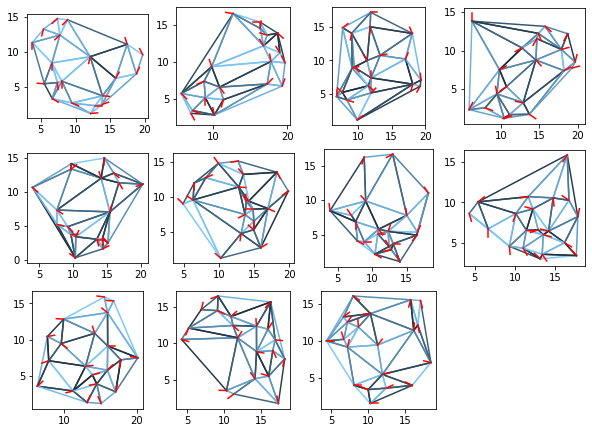

In [82]:
fig = plt.figure(figsize=(10,10))
for i in range(getNFrames(d)):
    (xy,tails) = extractTads(d,frame=i)
    pairs = findNeighbors(xy)
    dist = findDistances(xy,pairs)
    ang = findAngles(tails,pairs)
    ax = fig.add_subplot(4,4,i+1)
    niceTadFigure(ax)